In [ ]:
cp -r ~/datasets/meetup/backup/CrudeOil ../

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


# Load Data

In [2]:
data = pd.read_csv("../CrudeOil/CL=F_daily.csv")
data.shape

(2517, 7)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-04-25,112.339996,113.480003,111.080002,112.279999,112.279999,209683.0
1,2011-04-26,112.150002,112.639999,111.120003,112.209999,112.209999,234441.0
2,2011-04-27,111.889999,113.400002,110.709999,112.760002,112.760002,338697.0
3,2011-04-28,113.129997,113.970001,111.690002,112.860001,112.860001,301604.0
4,2011-04-29,112.820000,114.180000,112.250000,113.930000,113.930000,201831.0


# Remove NaN

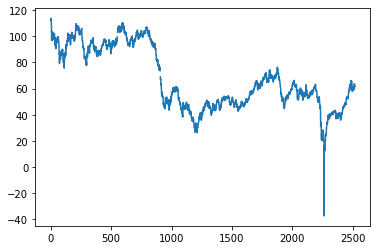

In [4]:
data.Close.plot()

In [5]:
pd.isna(data.Close).sum()

23

In [6]:
series = data.Close[~pd.isna(data.Close)]
time_str = data.Date[~pd.isna(data.Close)]
print(series.shape)

(2494,)


# Define Param

In [7]:
window_size = 14
delay = 10

# Split Train/Valid

In [8]:
train_ratio = 0.95
split_time = int(len(data)*train_ratio)
print("split_time_str: ", time_str.iloc[split_time])

split_time_str:  2020-11-19


In [9]:
x_train = series[:split_time]
x_valid = series[split_time-(window_size+delay):]
x_forcast = series[-window_size:]
print(x_train.shape, x_valid.shape, x_forcast.shape)

(2391,) (127,) (14,)


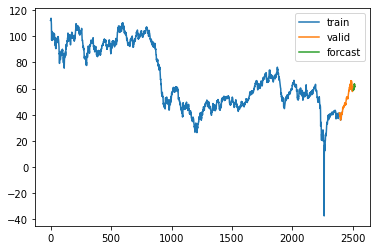

In [10]:
plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(x_forcast, label="forcast")
plt.legend()

# Prepare Windowed Data

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, delay=1, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + delay, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + delay))
    if train:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:window_size], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)  
    return dataset

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [13]:
batch_size = 32
shuffle_buffer_size = 1000

time_str_train = time_str[(window_size+delay):split_time]
time_str_valid = time_str[split_time:]
print(time_str_train.shape, time_str_valid.shape)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size, delay=delay)
valid_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size, delay=delay, train=False)

(2367,) (103,)


In [14]:
def check_data(dataset):
    count=0
    for i,(x,y) in enumerate(dataset):
        count+=x.shape[0]
        if i==0:
            print("x.shape: ", x.shape, ", y.shape: ", y.shape)
    print("#records: ", count)
    
check_data(train_set)
check_data(valid_set)

x.shape:  (128, 14) , y.shape:  (128,)
#records:  2368
x.shape:  (104, 14) , y.shape:  (104,)
#records:  104


# Train Model

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [28]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=valid_set, epochs=20)

Epoch 1/20
19/19 [==============================] - 1s 22ms/step - loss: 74.5428 - mae: 74.5428 - val_loss: 41.3772 - val_mae: 41.3772
Epoch 2/20
19/19 [==============================] - 0s 19ms/step - loss: 45.3378 - mae: 45.3378 - val_loss: 11.7705 - val_mae: 11.7705
Epoch 3/20
19/19 [==============================] - 0s 19ms/step - loss: 7.6727 - mae: 7.6727 - val_loss: 4.5386 - val_mae: 4.5386
Epoch 4/20
19/19 [==============================] - 0s 19ms/step - loss: 4.5507 - mae: 4.5507 - val_loss: 4.1935 - val_mae: 4.1935
Epoch 5/20
19/19 [==============================] - 0s 22ms/step - loss: 4.5187 - mae: 4.5187 - val_loss: 4.8647 - val_mae: 4.8647
Epoch 6/20
19/19 [==============================] - 0s 13ms/step - loss: 4.3216 - mae: 4.3216 - val_loss: 4.4671 - val_mae: 4.4671
Epoch 7/20
19/19 [==============================] - 0s 19ms/step - loss: 4.3227 - mae: 4.3227 - val_loss: 4.4233 - val_mae: 4.4233
Epoch 8/20
19/19 [==============================] - 0s 13ms/step - loss: 4.

# Validation

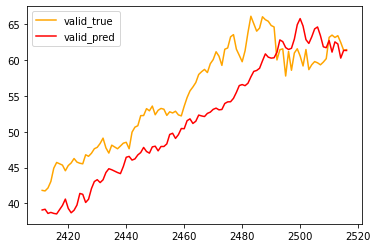

In [29]:
y_true = []
y_pred = []

for x,y in valid_set:
    #print(x.shape, y.shape)
    y_hat = model.predict(x)
    #print(y_hat.shape, y_hat.dtype)
    y_true += list(y)
    y_pred = list(y_hat)

time_index = list(x_valid[window_size+delay-1:].index)
plt.plot(time_index, y_true, label="valid_true",c="orange")
plt.plot(time_index, y_pred, label="valid_pred",c="red")
plt.legend()

In [30]:
time_str_valid

2412    2020-11-19
2413    2020-11-20
2414    2020-11-23
2415    2020-11-24
2416    2020-11-25
           ...    
2512    2021-04-16
2513    2021-04-19
2514    2021-04-20
2515    2021-04-21
2516    2021-04-22
Name: Date, Length: 103, dtype: object

# Forecast

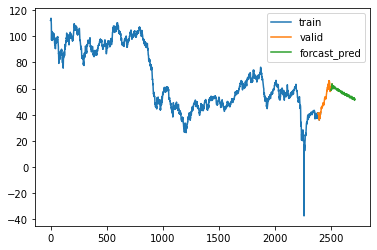

In [31]:
forcast_days = 200
forcast_data = list(x_forcast.values)
time_index = list(x_forcast.index)

for day in range(forcast_days):
    x = np.array(forcast_data[day:day+window_size])[np.newaxis]
    y_hat = model.predict(x)
    forcast_data.append(int(y_hat))
    time_index.append(time_index[-1]+1)


plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(time_index, forcast_data, label="forcast_pred")
plt.legend()    


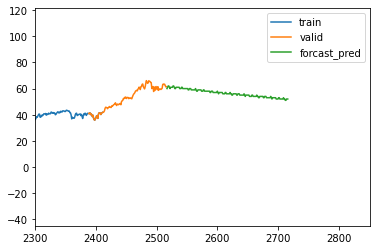

In [32]:
plt.plot(x_train, label="train")
plt.plot(x_valid, label="valid")
plt.plot(time_index[-forcast_days:], forcast_data[-forcast_days:], label="forcast_pred")
plt.xlim([2300,None])
plt.legend()  